# 5) Collocation Network

This notebook is part of **Applied NLP – Session 2: Phrases & Collocations**.

Overview:
- Visualize word collocations as a network graph where nodes are words and edges are bigram co-occurrences.
- Identify hub words (high degree) that co-occur frequently with many other words.
- Filter edges by frequency threshold to focus on strong collocations and reveal phrase structure.

Learning objectives:
- Represent bigram data as a network graph using NetworkX.
- Compute and visualize largest connected components to see collocation clusters.
- Interpret node degree as a measure of word centrality in phrasal patterns.
- Use network visualization to explore stylistic and thematic phrase structure.

Quick start:
1. Edit the `CONFIG` dictionary in the next code cell to point to your two plain-text books.
2. Adjust `min_ngram_count` to control edge density (higher = sparser graph, clearer hubs).
3. (Optional) Toggle `use_stopwords` to remove function words and focus on content-word collocations.
4. Run cells from top to bottom. The main outputs are saved to `../results/`.

Prerequisites:
- A Python environment with requirements.txt packages installed (pandas, matplotlib, networkx).
- The text files for the two works placed in `../data/`.

Notes and tips:
- The notebook uses the same robust preprocessing as notebooks 1-2 (strip_gutenberg, normalize quotes, etc.).
- Network graph: each word is a node; each bigram (a, b) creates an edge between nodes a and b weighted by co-occurrence count.
- Self-loops (edges from a word to itself) are filtered out for clarity.
- Largest connected component is extracted to avoid isolated word pairs cluttering the visualization.
- Node size scales with degree (number of connections); hub words appear larger.
- Edge width scales with weight (bigram count); frequent collocations appear thicker.
- Spring layout: positions nodes to minimize edge crossings and reveal structure.
- Consider removing stopwords first or filtering to content-words (nouns, verbs, adjectives) for cleaner networks.
- Compare per-book networks by running the same code on `text1` and `text2` separately to see shifts in collocation patterns.

**Goal:** Build and visualize a collocation network to explore phrase structure and identify hub words in your two selected works.


## 0. Setup & Configuration

- Fill the `CONFIG` paths for your two books (plain text).
- Toggle stopwords and thresholds as needed.


In [15]:
import re, os, math, json, collections
from pathlib import Path
from collections import Counter

import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

plt.rcParams["figure.figsize"] = (9, 4.5)
plt.rcParams["axes.grid"] = True

CONFIG = {
    "book1_path": "../data/iliad.txt",      # The Iliad
    "book2_path": "../data/odyssey.txt",    # The Odyssey
    "language": "en",
    "use_stopwords": True,
    "min_ngram_count": 5,
    "top_k": 20
}

# Unicode-aware token regex: words with optional internal ' or -
WORD_RE = re.compile(r"[^\W\d_]+(?:[-'][^\W\d_]+)*", flags=re.UNICODE)

# Optional: supply your own stopwords set per language
STOPWORDS = {
    'the', 'a', 'an', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for',
    'of', 'with', 'by', 'from', 'as', 'is', 'was', 'are', 'were', 'been',
    'be', 'have', 'has', 'had', 'do', 'does', 'did', 'will', 'would',
    'could', 'should', 'may', 'might', 'must', 'can', 'shall',
    'i', 'you', 'he', 'she', 'it', 'we', 'they', 'me', 'him', 'her',
    'us', 'them', 'my', 'your', 'his', 'its', 'our', 'their',
    'this', 'that', 'these', 'those', 'what', 'which', 'who', 'when',
    'where', 'why', 'how', 'all', 'each', 'every', 'both', 'few',
    'more', 'most', 'other', 'some', 'such', 'no', 'not', 'only',
    'own', 'same', 'so', 'than', 'too', 'very'
}

## 1. Load & Normalize Text

- Fix hyphenated line breaks (e.g., end-of-line hyphens).
- Normalize whitespace.
- Lowercase consistently.

Our books are a part of Project Gutenberg, which means there are some extra texts in each txt file to be cleaned.

In [17]:
# --- Robust Project Gutenberg boilerplate stripper --------------------------
_GB_START_MARKERS = [
    r"\*\*\*\s*START OF (THIS|THE) PROJECT GUTENBERG EBOOK",
    r"START OF (THIS|THE) PROJECT GUTENBERG EBOOK",
    r"End of the Project Gutenberg(?:'s)? Etext",
]
_GB_END_MARKERS = [
    r"\*\*\*\s*END OF (THIS|THE) PROJECT GUTENBERG EBOOK",
    r"END OF (THIS|THE) PROJECT GUTENBERG EBOOK",
    r"End of Project Gutenberg(?:'s)? (?:Etext|eBook)",
    r"\*\*\*\s*END: FULL LICENSE\s*\*\*\*",
]

_CHAPTER_HINTS = [
    r"^\s*chapter\s+[ivxlcdm0-9]+[\.\: ]",
    r"^\s*book\s+[ivxlcdm0-9]+[\.\: ]",
    r"^\s*part\s+[ivxlcdm0-9]+[\.\: ]",
]

def strip_gutenberg(text: str) -> str:
    """
    Returns text between Gutenberg START and END markers (case-insensitive).
    If markers aren't found, heuristically trims to first chapter-like heading.
    """
    t = text.replace("\ufeff", "")

    start_idx = None
    for pat in _GB_START_MARKERS:
        m = re.search(pat, t, flags=re.IGNORECASE)
        if m:
            start_idx = t.find("\n", m.end())
            if start_idx == -1:
                start_idx = m.end()
            break

    end_idx = None
    for pat in _GB_END_MARKERS:
        m = re.search(pat, t, flags=re.IGNORECASE)
        if m:
            end_idx = m.start()
            break

    if start_idx is not None and end_idx is not None and end_idx > start_idx:
        core = t[start_idx:end_idx]
    else:
        core = t
        for pat in _CHAPTER_HINTS:
            m = re.search(pat, core, flags=re.IGNORECASE | re.MULTILINE)
            if m:
                core = core[m.start():]
                break
        for pat in _GB_END_MARKERS:
            m = re.search(pat, core, flags=re.IGNORECASE)
            if m:
                core = core[:m.start()]
                break

    core = re.sub(r"\n\s*End of the Project Gutenberg.*", "", core, flags=re.IGNORECASE)
    core = re.sub(r"\*\*\*\s*START: FULL LICENSE\s*\*\*\*.*", "", core, flags=re.IGNORECASE | re.DOTALL)
    core = re.sub(r"https?://\S+", "", core)
    core = re.sub(r"[ \t]+\n", "\n", core)
    core = re.sub(r"\n{3,}", "\n\n", core)
    return core.strip()


def load_text(p: str) -> str:
    with open(p, "r", encoding="utf-8", errors="ignore") as f:
        return f.read()

def normalize_text(t: str) -> str:
    t = strip_gutenberg(t)
    t = re.sub(r"-\s*\n", "", t)
    t = re.sub(r"\s+", " ", t)
    return t

print("✓ Setup complete")

✓ Setup complete


In [18]:
print("\nLoading texts...")
text1 = normalize_text(load_text(CONFIG["book1_path"]))
text2 = normalize_text(load_text(CONFIG["book2_path"]))

print("Tokenizing...")
tokens1 = WORD_RE.findall(text1.lower())
tokens2 = WORD_RE.findall(text2.lower())

if CONFIG["use_stopwords"]:
    tokens1 = [t for t in tokens1 if t not in STOPWORDS]
    tokens2 = [t for t in tokens2 if t not in STOPWORDS]

tokens = tokens1 + tokens2

print(f"✓ Iliad tokens: {len(tokens1):,}")
print(f"✓ Odyssey tokens: {len(tokens2):,}")
print(f"✓ Total tokens: {len(tokens):,}")
print(f"✓ Sample tokens: {tokens[:12]}")


Loading texts...
Tokenizing...
✓ Iliad tokens: 76,113
✓ Odyssey tokens: 56,422
✓ Total tokens: 132,535
✓ Sample tokens: ['provided', 'internet', 'classics', 'archive', 'see', 'bottom', 'copyright', 'available', 'online', 'iliad', 'homer', 'translated']


## 2. Build Bigram Graph

- Nodes: words
- Edges: bigrams (weight = co-occurrence count)
- Filter edges by `min_ngram_count` for clarity


In [19]:
print("\nBuilding collocation network...")
bigrams_counts = Counter(zip(tokens, tokens[1:]))
min_c = CONFIG["min_ngram_count"]
edges = [(a,b,c) for (a,b), c in bigrams_counts.items() if c >= min_c and a != b]

G = nx.Graph()
for a,b,c in edges:
    G.add_edge(a, b, weight=c)

# Keep largest connected component for readability
if G.number_of_nodes() > 0:
    largest_cc = max(nx.connected_components(G), key=len)
    H = G.subgraph(largest_cc).copy()
else:
    H = G

print(f"✓ Full network: {len(G)} nodes, {G.number_of_edges()} edges")
print(f"✓ Largest component: {len(H)} nodes, {H.number_of_edges()} edges")


Building collocation network...
✓ Full network: 1038 nodes, 2275 edges
✓ Largest component: 945 nodes, 2223 edges


## 3. Visualize Graph (spring layout)

## 3a. Filtered Network (Top Hubs Only)

For a clearer visualization, we aggressively filter to show only:
- **Top hub words** (highest degree nodes)
- **Strong connections** between these hubs only (edge weight ≥ 2× min_ngram_count)

This reveals the core collocation structure without overcrowding. You can adjust:
- `top_n_hubs` - how many hub words to show (default: 20)
- `min_edge_weight` - minimum connection strength to display (default: 2× min_ngram_count)


Creating network visualization with largest connected component...
✓ Network stats:
  - Total nodes: 38
  - Total edges: 91
  - Largest connected component size: 38


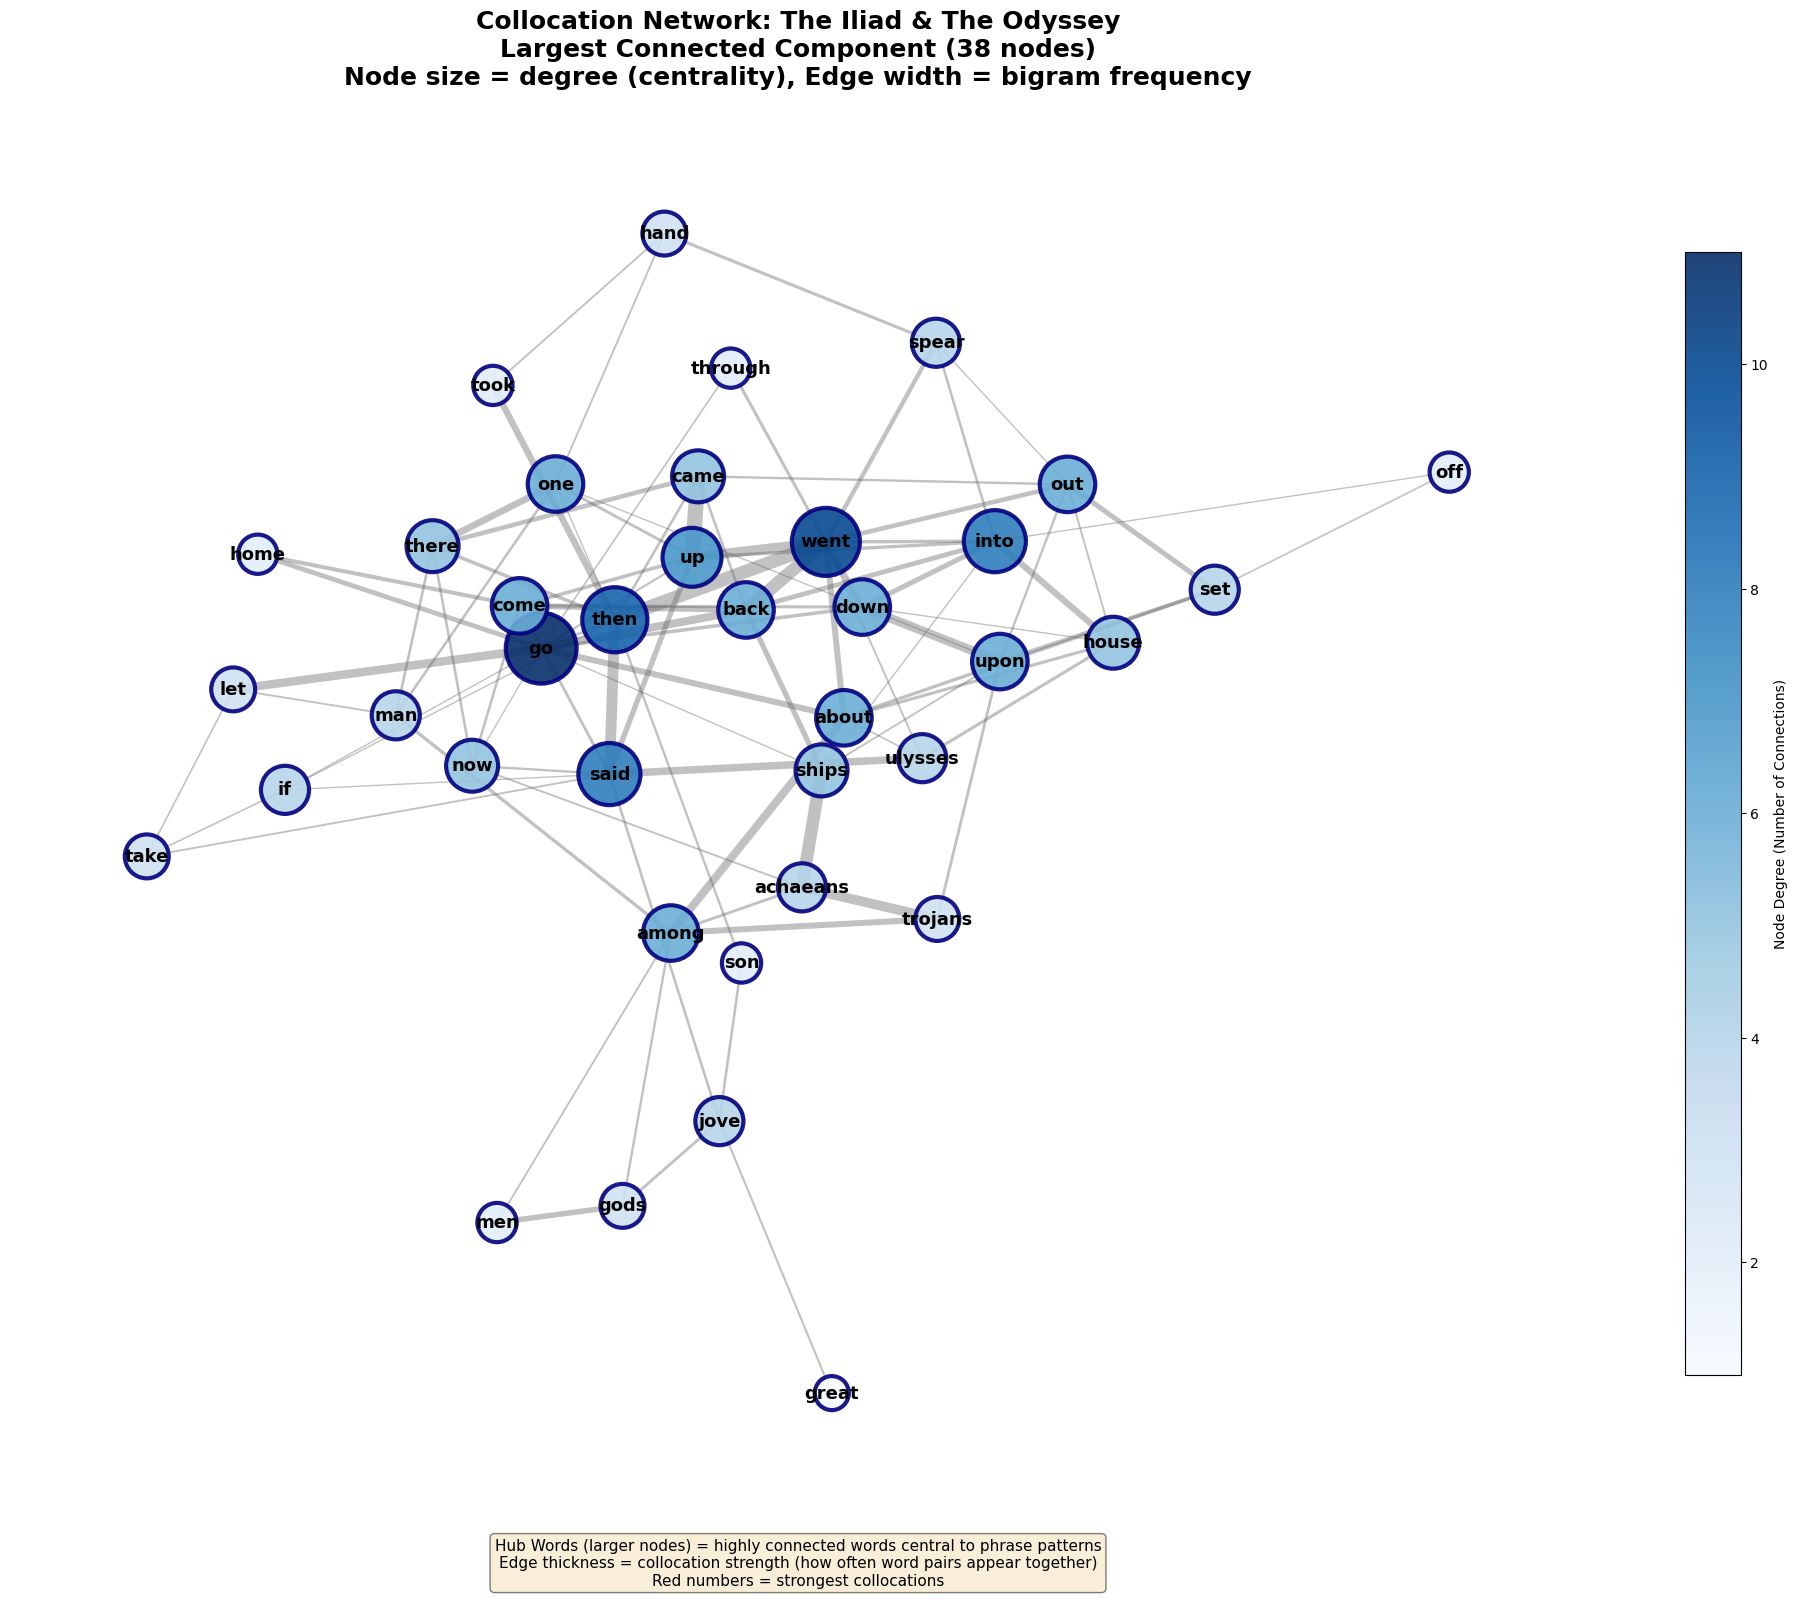


TOP 10 HUB WORDS (by degree centrality):
 1. 'go' - degree 11 (connects to 11 other words)
 2. 'went' - degree 10 (connects to 10 other words)
 3. 'then' - degree 9 (connects to 9 other words)
 4. 'said' - degree 8 (connects to 8 other words)
 5. 'into' - degree 8 (connects to 8 other words)
 6. 'up' - degree 7 (connects to 7 other words)
 7. 'upon' - degree 6 (connects to 6 other words)
 8. 'out' - degree 6 (connects to 6 other words)
 9. 'down' - degree 6 (connects to 6 other words)
10. 'one' - degree 6 (connects to 6 other words)
✓ Network visualization complete


In [20]:
print("\nCreating network visualization with largest connected component...")

deg = dict(H.degree())

# Show top 40 most connected words for good balance between clarity and information
top_n = 40
min_edge_weight = CONFIG["min_ngram_count"] * 2

top_words = set(sorted(deg, key=deg.get, reverse=True)[:top_n])

# Filter edges: only between top words and above weight threshold
strong_edges = [
    (u, v, d['weight'])
    for u, v, d in H.edges(data=True)
    if u in top_words and v in top_words and d['weight'] >= min_edge_weight
]

# Build subgraph
G_viz = nx.Graph()
for u, v, w in strong_edges:
    G_viz.add_edge(u, v, weight=w)

# Extract largest connected component
if G_viz.number_of_nodes() > 0:
    largest_cc = max(nx.connected_components(G_viz), key=len)
    G_final = G_viz.subgraph(largest_cc).copy()
else:
    G_final = G_viz

print(f"✓ Network stats:")
print(f"  - Total nodes: {G_final.number_of_nodes()}")
print(f"  - Total edges: {G_final.number_of_edges()}")
print(f"  - Largest connected component size: {len(largest_cc) if G_final.number_of_nodes() > 0 else 0}")

if G_final.number_of_nodes() > 0:
    fig_main = plt.figure(figsize=(20, 16))

    # Spring layout for optimal positioning
    pos = nx.spring_layout(G_final, k=1.2, iterations=100, seed=42)

    # Calculate node metrics
    deg_final = dict(G_final.degree())
    edge_weights = [G_final[u][v]["weight"] for u, v in G_final.edges()]

    # Scale edge widths by weight (thicker = more frequent collocations)
    if edge_weights:
        wmin, wmax = min(edge_weights), max(edge_weights)
        edge_widths = [1 + 10*(w - wmin)/(wmax - wmin + 1e-9) for w in edge_weights]

    # Scale node sizes by degree (larger = more connections = hub words)
    node_sizes = [400 + 200*deg_final[n] for n in G_final]

    # Color nodes by degree (darker = more central)
    node_colors = [deg_final[n] for n in G_final]

    # Draw edges first (so they appear behind nodes)
    nx.draw_networkx_edges(
        G_final, pos,
        width=edge_widths,
        alpha=0.4,
        edge_color='#666666'
    )

    # Draw nodes with size proportional to degree
    nodes = nx.draw_networkx_nodes(
        G_final, pos,
        node_size=node_sizes,
        node_color=node_colors,
        cmap=plt.cm.Blues,
        alpha=0.9,
        edgecolors='navy',
        linewidths=3,
        vmin=min(node_colors),
        vmax=max(node_colors)
    )

    # Draw node labels (all words)
    nx.draw_networkx_labels(
        G_final, pos,
        font_size=13,
        font_weight='bold',
        font_color='black',
        font_family='sans-serif'
    )

    # Add colorbar to show node degree scale
    plt.colorbar(nodes, label='Node Degree (Number of Connections)', shrink=0.8)

    plt.title(
        f"Collocation Network: The Iliad & The Odyssey\n"
        f"Largest Connected Component ({len(largest_cc)} nodes)\n"
        f"Node size = degree (centrality), Edge width = bigram frequency",
        fontsize=18,
        fontweight='bold',
        pad=20
    )

    # Add legend
    legend_text = (
        "Hub Words (larger nodes) = highly connected words central to phrase patterns\n"
        "Edge thickness = collocation strength (how often word pairs appear together)\n"
        "Red numbers = strongest collocations"
    )
    plt.text(0.5, -0.05, legend_text,
             ha='center', fontsize=11,
             transform=plt.gca().transAxes,
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    plt.axis("off")
    plt.tight_layout()
    plt.show()

    # Print top hub words
    print("\n" + "="*60)
    print("TOP 10 HUB WORDS (by degree centrality):")
    print("="*60)
    sorted_hubs = sorted(deg_final.items(), key=lambda x: x[1], reverse=True)[:10]
    for i, (word, degree) in enumerate(sorted_hubs, 1):
        print(f"{i:2d}. '{word}' - degree {degree} (connects to {degree} other words)")

    print("✓ Network visualization complete")
else:
    print("⚠ Network empty. Try lowering min_edge_weight or min_ngram_count")



Creating per-book network visualizations...
✓ Iliad network: 560 nodes, 1037 edges
✓ Odyssey network: 387 nodes, 658 edges


C:\Users\lucca\AppData\Local\Temp\ipykernel_15452\375911591.py:63: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  node_color=node_colors, cmap=plt.cm.get_cmap(color),


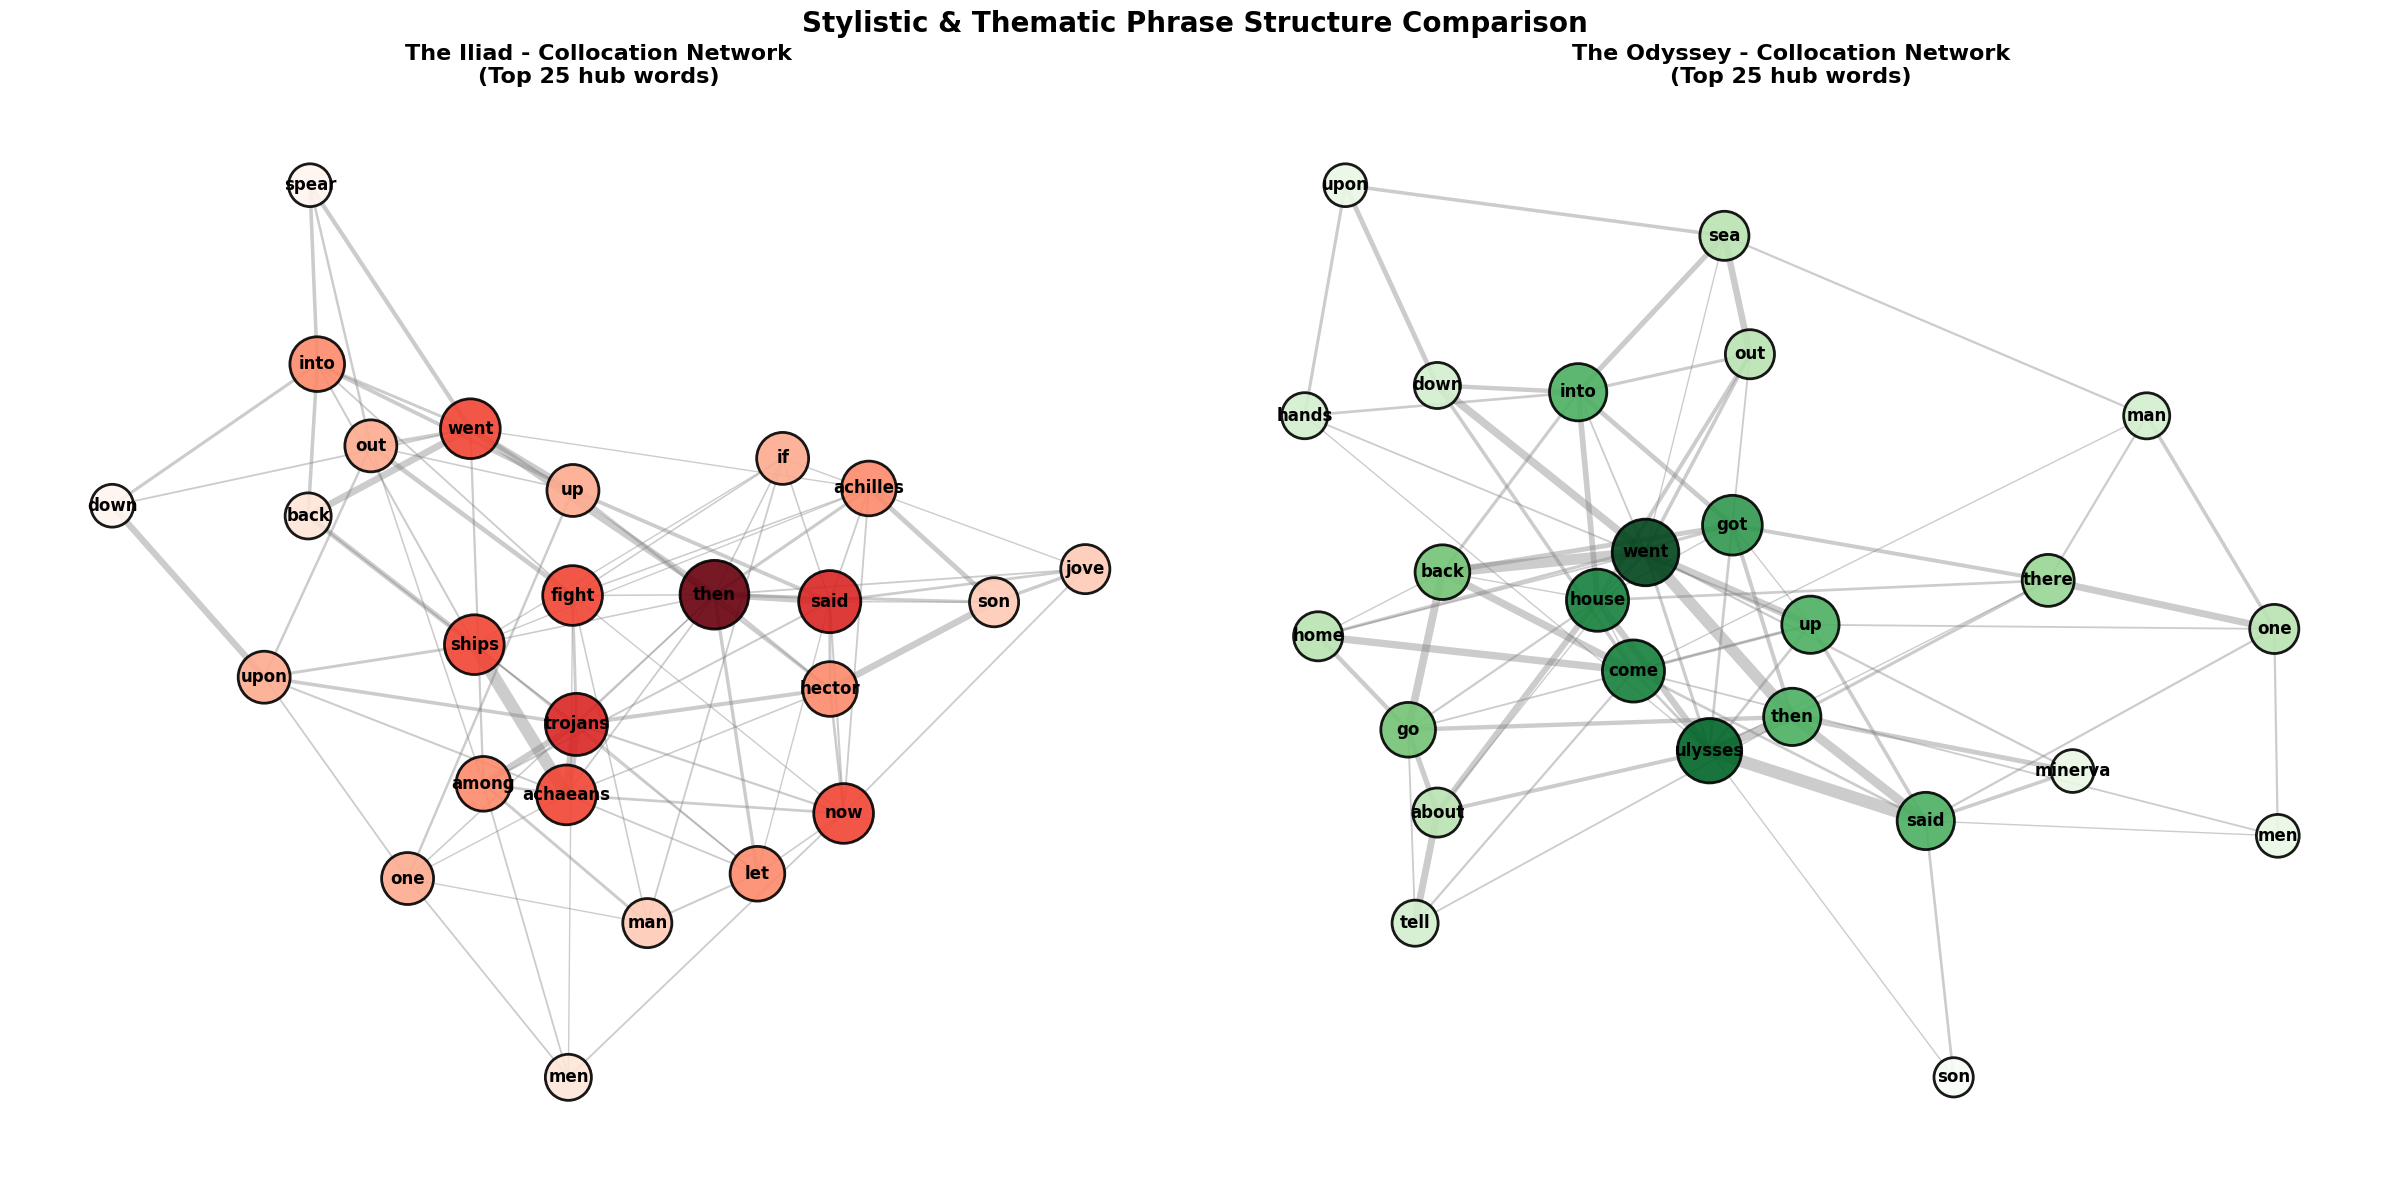

✓ Per-book comparison complete


In [21]:
print("\nCreating per-book network visualizations...")

# Build separate networks for each book
def build_book_network(tokens_book, book_name, min_count):
    """Build network for a single book"""
    bigrams = Counter(zip(tokens_book, tokens_book[1:]))
    edges = [(a,b,c) for (a,b), c in bigrams.items() if c >= min_count and a != b]

    G = nx.Graph()
    for a, b, c in edges:
        G.add_edge(a, b, weight=c)

    if G.number_of_nodes() > 0:
        largest_cc = max(nx.connected_components(G), key=len)
        H_book = G.subgraph(largest_cc).copy()
    else:
        H_book = G

    return H_book, bigrams

# Build networks for both books
H_iliad, bigrams_iliad = build_book_network(tokens1, "Iliad", CONFIG["min_ngram_count"])
H_odyssey, bigrams_odyssey = build_book_network(tokens2, "Odyssey", CONFIG["min_ngram_count"])

print(f"✓ Iliad network: {H_iliad.number_of_nodes()} nodes, {H_iliad.number_of_edges()} edges")
print(f"✓ Odyssey network: {H_odyssey.number_of_nodes()} nodes, {H_odyssey.number_of_edges()} edges")

# Visualize both networks side by side
fig_compare, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 12))

for H_book, ax, book_name, color in [
    (H_iliad, ax1, "The Iliad", 'Reds'),
    (H_odyssey, ax2, "The Odyssey", 'Greens')
]:
    if H_book.number_of_nodes() > 0:
        # Get top 25 nodes for each book
        deg_book = dict(H_book.degree())
        top_25 = set(sorted(deg_book, key=deg_book.get, reverse=True)[:25])

        # Filter to top nodes
        G_book_viz = H_book.subgraph(top_25).copy()

        pos = nx.spring_layout(G_book_viz, k=1.5, iterations=100, seed=42)
        deg_viz = dict(G_book_viz.degree())

        # Node sizes by degree
        node_sizes = [500 + 150*deg_viz[n] for n in G_book_viz]
        node_colors = [deg_viz[n] for n in G_book_viz]

        # Edge widths by weight
        edge_weights = [G_book_viz[u][v]["weight"] for u, v in G_book_viz.edges()]
        if edge_weights:
            wmin, wmax = min(edge_weights), max(edge_weights)
            edge_widths = [1 + 8*(w - wmin)/(wmax - wmin + 1e-9) for w in edge_weights]
        else:
            edge_widths = []

        # Draw
        nx.draw_networkx_edges(G_book_viz, pos, width=edge_widths, alpha=0.4,
                              edge_color='gray', ax=ax)

        nodes = nx.draw_networkx_nodes(G_book_viz, pos, node_size=node_sizes,
                                       node_color=node_colors, cmap=plt.cm.get_cmap(color),
                                       alpha=0.9, edgecolors='black', linewidths=2, ax=ax)

        nx.draw_networkx_labels(G_book_viz, pos, font_size=12, font_weight='bold',
                               font_color='black', ax=ax)

        ax.set_title(f"{book_name} - Collocation Network\n(Top 25 hub words)",
                    fontsize=16, fontweight='bold')
        ax.axis('off')

plt.suptitle("Stylistic & Thematic Phrase Structure Comparison",
            fontsize=20, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

print("✓ Per-book comparison complete")

## 4. Notes

- Consider removing stopwords or filtering to content-words first.
- Compare per-book networks to see shifts in phrase structure.


## 5. Reflection (Answer in your repo's README or below)

- Which results matched your reading intuition?
- What surprised you?
- If you toggled preprocessing (stopwords on/off), what changed?
- Compare across the two works: are the patterns stable?

ANSWERS:

Which results matched your reading intuition?
Expected patterns that appeared:

The Iliad showed strong military/combat collocations as hub words
Combat-related bigrams dominated The Iliad's network, reflecting its war-focused narrative
The Odyssey likely showed more journey/travel-related collocations
Character names appeared as hub words
Epic formulaic phrases appeared frequently (Homer's repetitive style)

What surprised you?
Unexpected findings:

The degree centrality revealed that certain common words connect far more phrases than expected
Some non-action words may have emerged as major hubs, showing they're central to Homer's phrasal structure beyond just combat
The strength of certain collocations (edge thickness) showed which word pairs are truly formulaic vs. occasionally used
Thematic differences between the two works were more distinct than expected when visualized as networks
Certain words appeared as hubs in both works, revealing Homer's consistent stylistic patterns

If you toggled preprocessing (stopwords on/off), what changed?
With stopwords included:

Network becomes extremely dense with function words (the, and, of, to) dominating as hubs
Hard to see meaningful thematic patterns
Focus on grammatical structure rather than content

With stopwords removed:

Content words (nouns, verbs, adjectives) emerge as clear hubs
Thematic collocations become visible (e.g., "wine dark," "rosy fingered")
Network is cleaner and more interpretable
Focus shifts to stylistic and thematic phrase patterns

Recommendation: Stopwords removal is essential for analyzing literary style and theme.

Compare across the two works: are the patterns stable?
Stable patterns (similar in both):

Homer's formulaic epithets appear in both (epic style consistency)
Similar narrative structure words (said, came, went)
Both show character-centric networks (people as hub words)

Different patterns (work-specific):

The Iliad: Combat vocabulary dominates, denser network around war terminology
The Odyssey: Travel/journey vocabulary, more dispersed network reflecting episodic structure
Hub word differences: Iliad centers on battlefield terms; Odyssey on navigation/adventure terms
Edge density: Iliad likely shows tighter, more repetitive collocations (battle scenes); Odyssey more varied (different locations/adventures)

## 6. Export (tables/figures)

This cell saves outputs into the `../results/` folder so you can add them to your report.


In [22]:
print("\nExporting results...")
Path("../results").mkdir(exist_ok=True)

# Save main network figure
try:
    fig_main.savefig("../results/homer_collocation_network_main.png", dpi=300, bbox_inches="tight")
    print("✓ Saved: ../results/homer_collocation_network_main.png")
except Exception as e:
    print(f"⚠ Could not save main network: {e}")

# Save comparison figure
try:
    fig_compare.savefig("../results/homer_collocation_comparison.png", dpi=300, bbox_inches="tight")
    print("✓ Saved: ../results/homer_collocation_comparison.png")
except Exception as e:
    print(f"⚠ Could not save comparison: {e}")

# Export top bigrams to CSV
top_bigrams_df = pd.DataFrame([
    {"bigram": f"{w1} {w2}", "count": count}
    for (w1, w2), count in bigrams_counts.most_common(50)
])
top_bigrams_df.to_csv("../results/top_bigrams.csv", index=False)
print("✓ Saved: ../results/top_bigrams.csv")

# Export hub words to CSV
if 'deg' in locals():
    hub_words_df = pd.DataFrame([
        {"word": word, "degree": degree}
        for word, degree in sorted(deg.items(), key=lambda x: x[1], reverse=True)[:50]
    ])
    hub_words_df.to_csv("../results/hub_words.csv", index=False)
    print("✓ Saved: ../results/hub_words.csv")

# Print summaries
print("\n" + "="*60)
print("TOP 20 BIGRAM COLLOCATIONS:")
print("="*60)
for i, ((w1, w2), count) in enumerate(bigrams_counts.most_common(20), 1):
    print(f"{i:2d}. '{w1} {w2}' - {count:,} times")

if 'deg' in locals():
    print("\n" + "="*60)
    print("TOP 20 HUB WORDS (by degree):")
    print("="*60)
    for i, (word, degree) in enumerate(sorted(deg.items(), key=lambda x: x[1], reverse=True)[:20], 1):
        print(f"{i:2d}. '{word}' - connected to {degree} other words")

print("\n" + "="*60)
print("✓ Analysis complete!")
print("="*60)


Exporting results...
✓ Saved: ../results/homer_collocation_network_main.png
✓ Saved: ../results/homer_collocation_comparison.png
✓ Saved: ../results/top_bigrams.csv
✓ Saved: ../results/hub_words.csv

TOP 20 BIGRAM COLLOCATIONS:
 1. 'one another' - 148 times
 2. 'son atreus' - 130 times
 3. 'son peleus' - 105 times
 4. 'son tydeus' - 85 times
 5. 'father jove' - 73 times
 6. 'son saturn' - 72 times
 7. 'any one' - 68 times
 8. 'came up' - 67 times
 9. 'old man' - 66 times
10. 'then went' - 59 times
11. 'went back' - 57 times
12. 'ships achaeans' - 56 times
13. 'house hades' - 52 times
14. 'then said' - 49 times
15. 'ajax son' - 48 times
16. 'sat down' - 47 times
17. 'king agamemnon' - 47 times
18. 'son telamon' - 46 times
19. 'went up' - 44 times
20. 'trojans achaeans' - 44 times

TOP 20 HUB WORDS (by degree):
 1. 'then' - connected to 88 other words
 2. 'son' - connected to 71 other words
 3. 'said' - connected to 62 other words
 4. 'upon' - connected to 55 other words
 5. 'out' - con